In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(size=(224, 224)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 85054675.12it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

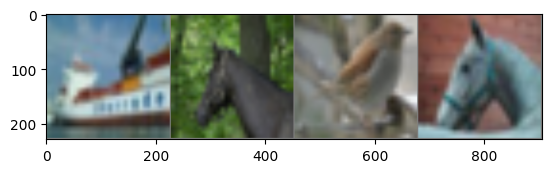

ship  horse bird  horse


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [10]:
id2label = {id:label for id, label in enumerate(classes)}
label2id = {label:id for id,label in id2label.items()}

In [12]:
label2id

{'plane': 0,
 'car': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

## Base model

In [13]:
from transformers import ViTImageProcessor, ViTForImageClassification

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [41]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [44]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs.logits, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}', end=" ")
            running_loss = 0.0
print('Finished Training')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[1,  2000] loss: 0.349 [1,  4000] loss: 0.121 [1,  6000] loss: 0.106 [1,  8000] loss: 0.090 [1, 10000] loss: 0.080 [1, 12000] loss: 0.077 Finished Training


In [45]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Accuracy of the network on the 10000 test images: 97 %


In [46]:
im = images[0,:,:,:].reshape(1,3,224,224).to(device)

In [47]:
%%timeit -n 10 -r 10
with torch.no_grad():
    pred = model(im)

14.8 ms ± 721 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [48]:
print("Base Model: ", model.num_parameters())

Base Model:  85806346


In [52]:
from transformers import pipeline

pipe = pipeline("image-classification", model=model, image_processor=processor, device=0)

id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [110]:
sample_input = torchvision.transforms.functional.to_pil_image(images[0], mode=None)

In [81]:
import time

#WARMUP
for _ in range(10):
  _ = pipe(sample_input)

#INFERENCE
start = time.time()
for _ in range(100):
  _ = pipe(sample_input)
total_time_model = time.time() - start
print("Общее время обработки 100 запросов базовой моделью:", total_time_model)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Общее время обработки 100 запросов базовой моделью: 4.139049768447876


In [125]:
from datasets import load_metric

accuracy_score = load_metric("accuracy")

In [144]:
model_preds = []
true_labels = []

for data in testloader:
    images, labels = data
    for image, label in zip(images, labels):
        im = torchvision.transforms.functional.to_pil_image(image, mode=None)
        model_preds.append(label2id[pipe(im)[0]['label']])
        true_labels.append(label)
print(accuracy_score.compute(predictions=model_preds, references=true_labels))

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(')
{'accuracy': 0.9744}


In [83]:
model.save_pretrained("transformersbook/vit_model")

In [92]:
from optimum.pipelines import pipeline

### Using optimum pipeline

In [94]:
checkpoint = '/content/transformersbook/vit_model'

In [ ]:
optimum_model1 = pipeline(
        task="image-classification",
        model=checkpoint,
        image_processor=processor,
        accelerator="ort",
        device=0
)

In [96]:
#WARMUP
for _ in range(10):
  _ = optimum_model1(sample_input)

#INFERENCE
start = time.time()
for _ in range(100):
  _ = optimum_model1(sample_input)
total_time_model = time.time() - start
print("Общее время обработки 100 запросов базовой моделью из optimum:", total_time_model)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Общее время обработки 100 запросов базовой моделью из optimum: 2.063542604446411


In [143]:
model_preds = []
true_labels = []

for data in testloader:
    images, labels = data
    for image, label in zip(images, labels):
        im = torchvision.transforms.functional.to_pil_image(image, mode=None)
        model_preds.append(label2id[optimum_model1(im)[0]['label']])
        true_labels.append(label)
print(accuracy_score.compute(predictions=model_preds, references=true_labels))

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(')
{'accuracy': 0.9744}
